<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Simple-centered-difference" data-toc-modified-id="Simple-centered-difference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Simple centered difference</a></span></li><li><span><a href="#Upstream-differencing" data-toc-modified-id="Upstream-differencing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Upstream differencing</a></span></li><li><span><a href="#Bott-(1989)-flux-correction" data-toc-modified-id="Bott-(1989)-flux-correction-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Bott (1989) flux correction</a></span></li><li><span><a href="#Central" data-toc-modified-id="Central-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Central</a></span></li><li><span><a href="#Upstream" data-toc-modified-id="Upstream-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Upstream</a></span></li><li><span><a href="#Flux--correction" data-toc-modified-id="Flux--correction-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Flux  correction</a></span></li></ul></div>

# Introduction

Notebook demonstrating 3 numerical advection schemes described in https://clouds.eos.ubc.ca/~phil/numeric/html_files/Lab_10.html

In [ ]:
"""
Module containing advection3 and, in time advection and advection2
"""
import matplotlib.cm as cmx
import matplotlib.colorbar as colorbar
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np

In [ ]:


def initialize(timesteps):
    """ initialize the physical system, horizontal grid size, etc
    """
    # below are the parameters that can be varied
    dx = 1
    u = 1.0
    dt = 0.45 * dx / u
    Numpoints = 290
    shift = Numpoints / 5
    c_0 = 1
    alpha = 0.01
    epsilon = 0.0001

    # create the concentration matrix and initialize it
    cmatrix = np.zeros((timesteps + 1, Numpoints + 4))
    cmatrix[0, 2 : Numpoints + 2] = c_0 * np.exp(
        -alpha * (np.arange(0, Numpoints) * dx - shift) ** 2
    )

    # set the boundary points
    cmatrix = boundary_conditions(cmatrix, 0, Numpoints)

    return dx, u, dt, Numpoints, shift, c_0, alpha, epsilon, cmatrix

In [3]:
def boundary_conditions(cmatrix, time, Numpoints):
    """Set boundary conditions (double thick so it work for Bott Scheme as well as central and upstream
    """
    cmatrix[0, 0] = cmatrix[1, Numpoints - 1]
    cmatrix[0, 1] = cmatrix[1, Numpoints]
    cmatrix[0, Numpoints + 2] = cmatrix[1, 3]
    cmatrix[0, Numpoints + 3] = cmatrix[1, 4]

    return cmatrix

In [4]:
def advect3_gettable(order, Numpoints):

    """read in the corresponding coefficient table for the calculation of coefficients for advection3
    """

    # create a matrix to store the table to be read in
    temp = np.zeros(5)
    ltable = np.zeros((order + 1, 5))

    fname = "Tables/l{0}_table.txt".format(order)
    fp = open(fname, "r")

    for i in range(order + 1):
        line = fp.readline()
        temp = line.split()
        ltable[i, :] = temp

    fp.close()
    return ltable

# Simple centered difference

In [5]:
def step_advect(timesteps, cmatrix, Numpoints, u, dt, dx):
    """Step algorithm for the Central Scheme"""
    for timecount in range(0, timesteps):

        cmatrix[timecount + 1, 1 : Numpoints - 1] = cmatrix[
            timecount, 1 : Numpoints - 1
        ] - (
            u
            * dt
            / (2 * dx)
            * (cmatrix[timecount, 2:Numpoints] - cmatrix[timecount, : Numpoints - 2])
        )

        cmatrix = boundary_conditions(cmatrix, timecount + 1, Numpoints)
    return cmatrix

# Upstream differencing

In [6]:
def step_advect2(timesteps, cmatrix, Numpoints, u, dt, dx):
    """Step algorithm for Upstream Scheme"""

    for timecount in range(0, timesteps):

        cmatrix[timecount + 1, 1:Numpoints] = cmatrix[timecount, 1:Numpoints] - (
            u
            * dt
            / dx
            * (cmatrix[timecount, 1:Numpoints] - cmatrix[timecount, : Numpoints - 1])
        )

        cmatrix = boundary_conditions(cmatrix, timecount + 1, Numpoints)
    return cmatrix

# Bott (1989) flux correction

In [ ]:
def step_advect3(timesteps, ltable, cmatrix, order, Numpoints, u, dt, dx, epsilon):
    """Step algorithm for Bott Scheme"""

    # create a matrix to store the current coefficients a(j, k)
    amatrix = np.zeros((order + 1, Numpoints))

    for timecount in range(0, timesteps):
        for base in range(0, 5):
            amatrix[0 : order + 1, 0:Numpoints] += np.dot(
                ltable[0 : order + 2, base : base + 1],
                cmatrix[timecount : timecount + 1, 0 + base : Numpoints + base],
            )

        # calculate I of c at j+1/2 , as well as I at j
        # as these values will be needed to calculate i at j+1/2 , as
        # well as i at j

        # calculate I of c at j+1/2(Iplus),
        # and at j(Iatj)
        Iplus = np.zeros(Numpoints)
        Iatj = np.zeros(Numpoints)

        tempvalue = 1 - 2 * u * dt / dx
        for k in range(order + 1):
            Iplus += (
                amatrix[k] * (1 - (tempvalue ** (k + 1))) / (k + 1) / (2 ** (k + 1))
            )
            Iatj += amatrix[k] * ((-1) ** k + 1) / (k + 1) / (2 ** (k + 1))
        Iplus[Iplus < 0] = 0
        Iatj = np.maximum(Iatj, Iplus + epsilon)

        # finally, calculate the current concentration
        cmatrix[timecount + 1, 3 : Numpoints + 2] = (
            cmatrix[timecount, 3 : Numpoints + 2]
            * (1 - Iplus[1:Numpoints] / Iatj[1:Numpoints])
            + cmatrix[timecount, 2 : Numpoints + 1]
            * Iplus[0 : Numpoints - 1]
            / Iatj[0 : Numpoints - 1]
        )

        # set the boundary condition at the first point
        cmatrix[timecount + 1, 2] = cmatrix[timecount + 1, Numpoints + 1]
        # set the other boundary points
        cmatrix = boundary_conditions(cmatrix, timecount + 1, Numpoints)

    return cmatrix

In [ ]:
def make_graph(cmatrix, timesteps, Numpoints, dt):
    """Create graphs of the model results using matplotlib.
    """

    # Create a figure with size 15, 5
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))

    # Set the figure title, and the axes labels.
    fig.text(
        0.25,
        0.95,
        "Concentrations Results from t = %.3fs to %.3fs" % (0, dt * timesteps),
    )
    ax.set_ylabel("Concentration")
    ax.set_xlabel("Grid Point")

    # We use color to differentiate lines at different times.  Set up the color map
    cmap = plt.get_cmap("nipy_spectral")
    cNorm = colors.Normalize(vmin=0, vmax=1.0 * timesteps)
    cNorm_inseconds = colors.Normalize(vmin=0, vmax=1.0 * timesteps * dt)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)

    # Only try to plot 20 lines, so choose an interval if more than that (i.e. plot
    # every interval lines
    interval = np.int(np.ceil(timesteps / 20))

    # Do the main plot
    for time in range(0, timesteps, interval):
        colorVal = scalarMap.to_rgba(time)
        ax.plot(cmatrix[time, :], color=colorVal)

    # Add the custom colorbar
    ax2 = fig.add_axes([0.95, 0.05, 0.05, 0.9])
    cb1 = colorbar.ColorbarBase(ax2, cmap=cmap, norm=cNorm_inseconds)
    cb1.set_label("Time (s)")
    return

In [9]:
def advection(timesteps):
    """Entry point for the Central Scheme"""
    dx, u, dt, Numpoints, shift, c_0, alpha, epsilon, cmatrix = initialize(timesteps)
    cmatrix = step_advect(timesteps, cmatrix, Numpoints, u, dt, dx)
    make_graph(cmatrix, timesteps, Numpoints, dt)

In [10]:
def advection2(timesteps):
    """Entry point for the Upstream Scheme"""
    dx, u, dt, Numpoints, shift, c_0, alpha, epsilon, cmatrix = initialize(timesteps)
    cmatrix = step_advect2(timesteps, cmatrix, Numpoints, u, dt, dx)
    make_graph(cmatrix, timesteps, Numpoints, dt)

In [11]:
def advection3(timesteps, order):
    """ Entry point for the Bott Scheme"""
    dx, u, dt, Numpoints, shift, c_0, alpha, epsilon, cmatrix = initialize(timesteps)
    ltable = advect3_gettable(order, Numpoints)
    cmatrix = step_advect3(
        timesteps, ltable, cmatrix, order, Numpoints, u, dt, dx, epsilon
    )
    make_graph(cmatrix, timesteps, Numpoints, dt)

# Central

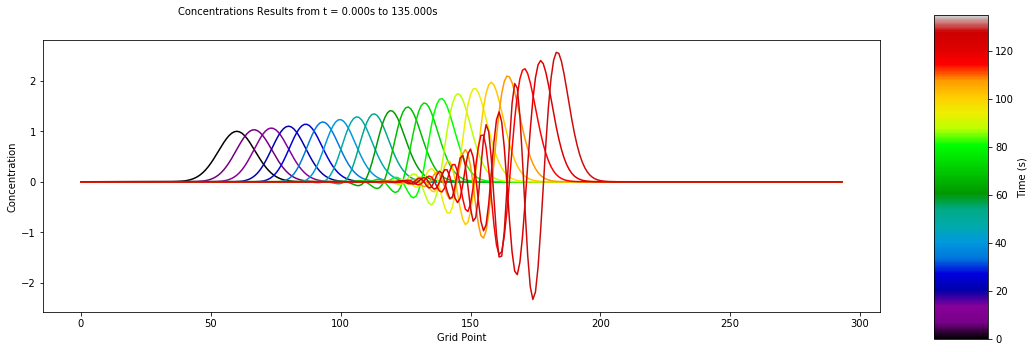

In [12]:
%matplotlib inline
advection(300)

# Upstream

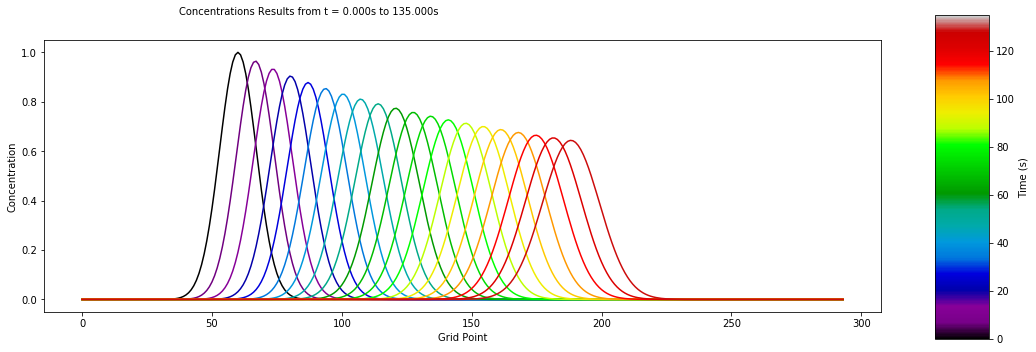

In [13]:
advection2(300)

# Flux  correction

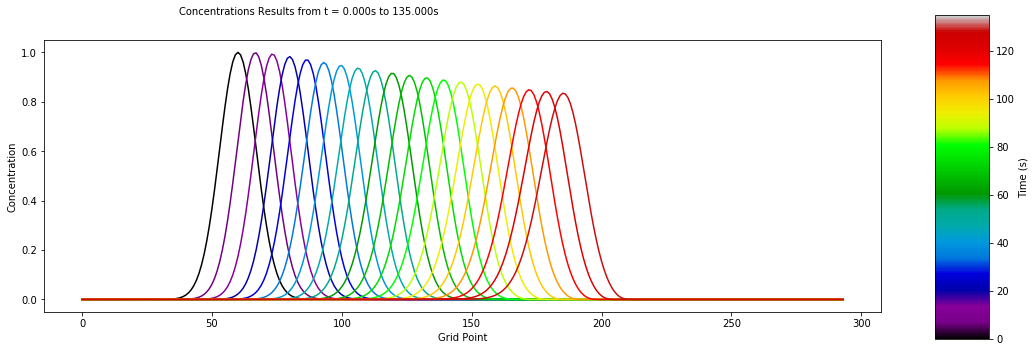

In [14]:
advection3(300, 4)